# 변경이 필요한 부분
- 구조의 변경 : 인코더-디코더 구조 -> 디코더 구조
- 디코더 내부의 구조 : 멀티헤드 셀프 어텐션 -> LayerNorm -> Feedforward Neural Network (FFNN) -> LayerNorm 구조로의 변경 필요
- 이외의 인코더, 인코더와 연결된 디코더 부분은 삭제 필요

# 패키지 임포트

In [952]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# 포지셔널 행렬

In [953]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

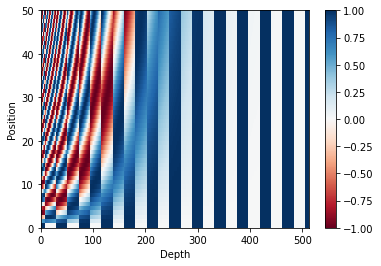

In [954]:
sample_pos_encoding = PositionalEncoding(50,512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 스케일드 닷 프로덕트 어텐션 함수

In [955]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션

In [956]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.query_dense = tf.keras.layers.Dense(d_model)
        self.key_dense = tf.keras.layers.Dense(d_model)
        self.value_dense = tf.keras.layers.Dense(d_model)
        self.final_dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask=None):
        batch_size = tf.shape(query)[0]
        query = self.split_heads(self.query_dense(query), batch_size)
        key = self.split_heads(self.key_dense(key), batch_size)
        value = self.split_heads(self.value_dense(value), batch_size)
        
        scaled_attention = tf.matmul(query, key, transpose_b=True)
        scaled_attention /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        
        if mask is not None:
            scaled_attention += (mask * -1e9)  # 마스킹 적용
        
        scaled_attention = tf.nn.softmax(scaled_attention, axis=-1)
        output = tf.matmul(scaled_attention, value)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        return self.final_dense(tf.reshape(output, (batch_size, -1, self.num_heads * self.depth)))

# 패딩 마스크

In [957]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [958]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


# 룩 어헤드 마스킹

In [959]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [960]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [961]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


# 디코더

In [962]:
# GPT-1의 디코더만 구현 (트랜스포머의 디코더 블록 활용)
class GPTDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(GPTDecoderLayer, self).__init__()
        # 멀티헤드 셀프 어텐션
        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # FFNN
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # 첫 번째 Dense 레이어
            tf.keras.layers.Dense(d_model)  # 두 번째 Dense 레이어
        ])
        
        # Layer Normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, look_ahead_mask=None):
        # 멀티헤드 셀프 어텐션
        attn_output = self.mha(x, x, x, mask=look_ahead_mask)  # Masked Self-Attention
        attn_output = self.dropout1(attn_output, training=training)
        
        # Add & Normalize (잔차 연결 + LayerNorm)
        out1 = self.layernorm1(x + attn_output)

        # Feedforward Neural Network (FFN)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Add & Normalize (잔차 연결 + LayerNorm)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2


In [963]:
# GPT 모델 정의
class GPT(tf.keras.Model):
    def __init__(self, vocab_size, d_model, num_heads, dff, num_layers, max_length, dropout_rate=0.1):
        super(GPT, self).__init__()
        
        # 입력 임베딩 레이어
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        
        # 포지셔널 인코딩 (학습 가능한 임베딩 형태로 구현)
        self.pos_encoding = tf.keras.layers.Embedding(max_length, d_model)
        
        # 디코더 레이어 (사용자 정의 GPTDecoderLayer를 반복적으로 쌓음)
        self.decoder_layers = [
            GPTDecoderLayer(d_model=d_model, num_heads=num_heads,
                            dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        
        # 드롭아웃
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        # 최종 출력 레이어 (어휘 크기만큼 출력)
        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, x, training):
        # 입력을 정수형으로 캐스팅
        x = tf.cast(x, tf.int32)
        
        # 시퀀스 길이 계산
        seq_len = tf.shape(x)[1]
        
        # 임베딩 + 포지셔널 인코딩
        x = self.embedding(x) + self.pos_encoding(tf.range(seq_len))
        
        # 드롭아웃 적용
        x = self.dropout(x, training=training)

        # 디코더 레이어를 순차적으로 통과
        for decoder_layer in self.decoder_layers:
            x = decoder_layer(x, training=training)  # Look-ahead Mask는 None으로 설정
        
        # 최종 출력 생성 (어휘 크기만큼의 로짓 반환)
        return self.final_layer(x)


# 챗봇의 병렬 데이터 받아오기

In [964]:
import csv

# 파일 경로 설정
file_path = "ChatbotData .csv"  # 실제 CSV 파일 경로로 변경

In [965]:
def load_and_preprocess_data(file_path, max_samples=50000, max_length=40):
    processed_data = []
    
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) >= 2:
                question, answer = row[0], row[1]
                question = preprocess_sentence(question)
                answer = preprocess_sentence(answer)
                
                # GPT-1 입력 포맷: "[START] 질문 [SEP] 답변 [END]"
                combined_text = f"[START] {question} [SEP] {answer} [END]"
                
                if len(combined_text.split()) <= max_length:
                    processed_data.append(combined_text)
    
    return processed_data

In [966]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.strip()
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r'[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣.?!, ]', ' ', sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [967]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
processed_data = load_and_preprocess_data(file_path)
print(f"Processed Data Sample: {processed_data[:5]}")  # 첫 5개의 샘플 출력
print('전체 샘플 수 :', len(processed_data))

Processed Data Sample: ['[START] Q [SEP] A [END]', '[START] 12시 땡 ! [SEP] 하루가 또 가네요 . [END]', '[START] 1지망 학교 떨어졌어 [SEP] 위로해 드립니다 . [END]', '[START] 3박4일 놀러가고 싶다 [SEP] 여행은 언제나 좋죠 . [END]', '[START] 3박4일 정도 놀러가고 싶다 [SEP] 여행은 언제나 좋죠 . [END]']
전체 샘플 수 : 11824


In [968]:
print('전처리 후의 22번째 샘플: {}'.format(processed_data[21]))

전처리 후의 22번째 샘플: [START] 가스비 비싼데 감기 걸리겠어 [SEP] 따뜻하게 사세요 ! [END]


# 병렬 데이터 전처리하기

### 1. 단어장 만들기

In [969]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(processed_data, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [970]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [971]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8180]
END_TOKEN의 번호 : [8181]


In [972]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8182


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [973]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 샘플: {}'.format(tokenizer.encode(processed_data[21])))

정수 인코딩 후의 21번째 샘플: [8015, 3, 1, 5767, 615, 3509, 146, 689, 3747, 853, 6, 4, 1, 2345, 518, 46, 5, 8017]


In [974]:
# 데이터셋 정수 인코딩 및 패딩
# 데이터셋 정수 인코딩 및 패딩
def tokenize_and_filter(inputs, max_length=40):
    tokenized_inputs = []
    
    for sentence in inputs:
        tokenized_sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN
        if len(tokenized_sentence) <= max_length:
            tokenized_inputs.append(tokenized_sentence)
    
    # 패딩 추가
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_length, padding='post'
    )
    
    return tokenized_inputs

print("슝=3")

슝=3


In [975]:
# 입력과 타겟 준비 (prepare_dataset 함수 호출)
# MAX_LENGTH 정의 (입력 시퀀스 길이)
MAX_LENGTH = 40

# 데이터셋 준비 함수 수정
def prepare_dataset(inputs, max_length):
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length, padding='post')
    targets = inputs[:, 1:]  # 타겟: 한 칸 오른쪽 이동
    inputs = inputs[:, :-1]  # 입력: 마지막 토큰 제거

    # 다시 패딩하여 길이 보정
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length, padding='post')
    targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=max_length, padding='post')

    return tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(10000).batch(64)


In [976]:
tokenized_inputs = tokenize_and_filter(processed_data)
dataset = prepare_dataset(tokenized_inputs, max_length=MAX_LENGTH)

# 디버깅: 데이터셋 확인
for x_batch, y_batch in dataset.take(1):
    print(f"Input shape: {x_batch.shape}")  # (batch_size, 40)
    print(f"Target shape: {y_batch.shape}")  # (batch_size, 40)


Input shape: (64, 40)
Target shape: (64, 40)


# 모델 정의 및 학습하기

In [977]:
def build_gpt_model(vocab_size, num_layers, d_model, num_heads, dff, max_length, dropout_rate):
    inputs = tf.keras.Input(shape=(max_length,), name="inputs")
    gpt = GPT(vocab_size, d_model, num_heads, dff, num_layers, max_length, dropout_rate)
    outputs = gpt(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="GPT_Model")

### 2. 손실 함수(Loss function)

In [978]:
def loss_function(y_true, y_pred):
    seq_len = tf.shape(y_pred)[1]  # 출력 시퀀스 길이 가져오기
    y_true = tf.reshape(y_true, shape=(-1, seq_len))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss *= mask
    
    return tf.reduce_mean(loss)


print("슝=3")

슝=3


### 1. 모델 생성

In [979]:
# 모델 생성
gpt_model = GPT(vocab_size=VOCAB_SIZE,
                d_model=D_MODEL,
                num_heads=NUM_HEADS,
                dff=DFF,
                num_layers=NUM_LAYERS,
                max_length=MAX_LENGTH,
                dropout_rate=DROPOUT_RATE)

# 모델 빌드
gpt_model.build(input_shape=(None, MAX_LENGTH))

# 모델 요약 출력
gpt_model.summary()

Model: "gpt_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     multiple                  4189184   
_________________________________________________________________
embedding_29 (Embedding)     multiple                  20480     
_________________________________________________________________
gpt_decoder_layer_36 (GPTDec multiple                  3152384   
_________________________________________________________________
gpt_decoder_layer_37 (GPTDec multiple                  3152384   
_________________________________________________________________
gpt_decoder_layer_38 (GPTDec multiple                  3152384   
_________________________________________________________________
gpt_decoder_layer_39 (GPTDec multiple                  3152384   
_________________________________________________________________
gpt_decoder_layer_40 (GPTDec multiple                  31523

### 3. 커스텀 된 학습률(Learning rate)

In [980]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

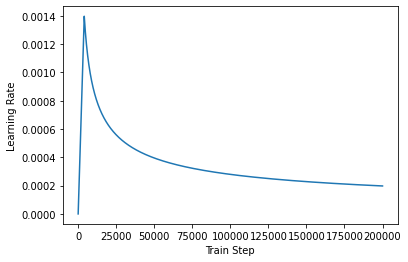

In [981]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [982]:
for layer in gpt_model.layers:
    layer.trainable = True

### 4. 모델 컴파일

In [983]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

gpt_model.compile(optimizer=optimizer, loss=loss_function)
print("슝=3")

슝=3


### 5. 훈련하기

In [984]:
EPOCHS = 10
gpt_model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 30s 132ms/step - loss: 3.5481
Epoch 2/10
185/185 [==============================] - 25s 135ms/step - loss: 2.2559
Epoch 3/10
185/185 [==============================] - 25s 137ms/step - loss: 1.9181
Epoch 4/10
185/185 [==============================] - 25s 135ms/step - loss: 1.5433
Epoch 5/10
185/185 [==============================] - 25s 135ms/step - loss: 1.0991
Epoch 6/10
185/185 [==============================] - 25s 136ms/step - loss: 0.7147
Epoch 7/10
185/185 [==============================] - 25s 136ms/step - loss: 0.4259
Epoch 8/10
185/185 [==============================] - 25s 135ms/step - loss: 0.2246
Epoch 9/10
185/185 [==============================] - 25s 135ms/step - loss: 0.0990
Epoch 10/10
185/185 [==============================] - 25s 136ms/step - loss: 0.0284


In [985]:
# 디버깅: 학습 데이터에 대한 모델 출력 확인
for x_batch, _ in dataset.take(1):
    predictions = gpt_model(x_batch[:1], training=False)  # 첫 번째 배치의 첫 번째 샘플 예측
    
    print(f"Predictions Shape: {predictions.shape}")  # 예측값의 텐서 크기 출력
    print(f"Predicted Logits: {predictions[0]}")  # 첫 번째 샘플의 예측 로짓 출력

Predictions Shape: (1, 40, 8182)
Predicted Logits: [[-2.5501251e-01  2.2308904e-01 -6.4507127e-01 ... -8.6531043e-04
   1.5345974e-01  4.1589421e-01]
 [-1.2983083e+00 -4.1092710e+00 -2.2756276e+00 ... -1.3719984e+00
  -1.3300039e+00 -1.5442977e+00]
 [-1.2723273e+00  2.3819162e+01 -2.1824803e+00 ... -1.3362412e+00
  -1.1046247e+00 -3.0590608e+00]
 ...
 [ 6.8893713e-01  6.4937168e-01  7.5389457e+00 ...  7.2308445e-01
   1.0138800e+00  8.3740675e-01]
 [ 6.5603393e-01  9.0847003e-01  8.3597841e+00 ...  7.0377272e-01
   9.5810908e-01  1.0793388e+00]
 [ 6.0360461e-01  1.0200118e+00  8.3783388e+00 ...  6.5096891e-01
   9.4108528e-01  7.1830833e-01]]


# 챗봇 테스트하기

In [986]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN,
        axis=0,
    )

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        combined_input = tf.concat([sentence, output_sequence], axis=-1)

        combined_input = tf.keras.preprocessing.sequence.pad_sequences(
            combined_input,
            maxlen=MAX_LENGTH,
            padding='post',
        )

        predictions = gpt_model(combined_input, training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        print(f"Step {i}: Predicted ID: {predicted_id.numpy()}")
        print(f"Output sequence so far: {output_sequence.numpy()}")

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [987]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print(f"입력: {sentence}")
    print(f"출력: {predicted_sentence}")

    return predicted_sentence

In [988]:
sentence_generation("배고프다")

Step 0: Predicted ID: [[22]]
Output sequence so far: [[8180]]
Step 1: Predicted ID: [[22]]
Output sequence so far: [[8180   22]]
Step 2: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22]]
Step 3: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22]]
Step 4: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22]]
Step 5: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22]]
Step 6: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22]]
Step 7: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22]]
Step 8: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22   22]]
Step 9: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22   22   22]]
Step 10: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22   22   22   22]]
Step 11: Predicted ID: [[22]]
Output seque

'요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요요'

In [989]:
sentence_generation("오늘 눈이 엄청 많이 온다!")

Step 0: Predicted ID: [[22]]
Output sequence so far: [[8180]]
Step 1: Predicted ID: [[22]]
Output sequence so far: [[8180   22]]
Step 2: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22]]
Step 3: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22]]
Step 4: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22]]
Step 5: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22]]
Step 6: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22]]
Step 7: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22]]
Step 8: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22   22]]
Step 9: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22   22   22]]
Step 10: Predicted ID: [[22]]
Output sequence so far: [[8180   22   22   22   22   22   22   22   22   22   22]]
Step 11: Predicted ID: [[22]]
Output seque

'요요요요요요요요요요요요요요요요 . [요요요요요요요요요요요요요요요요요요요요요요요'

# model.summary

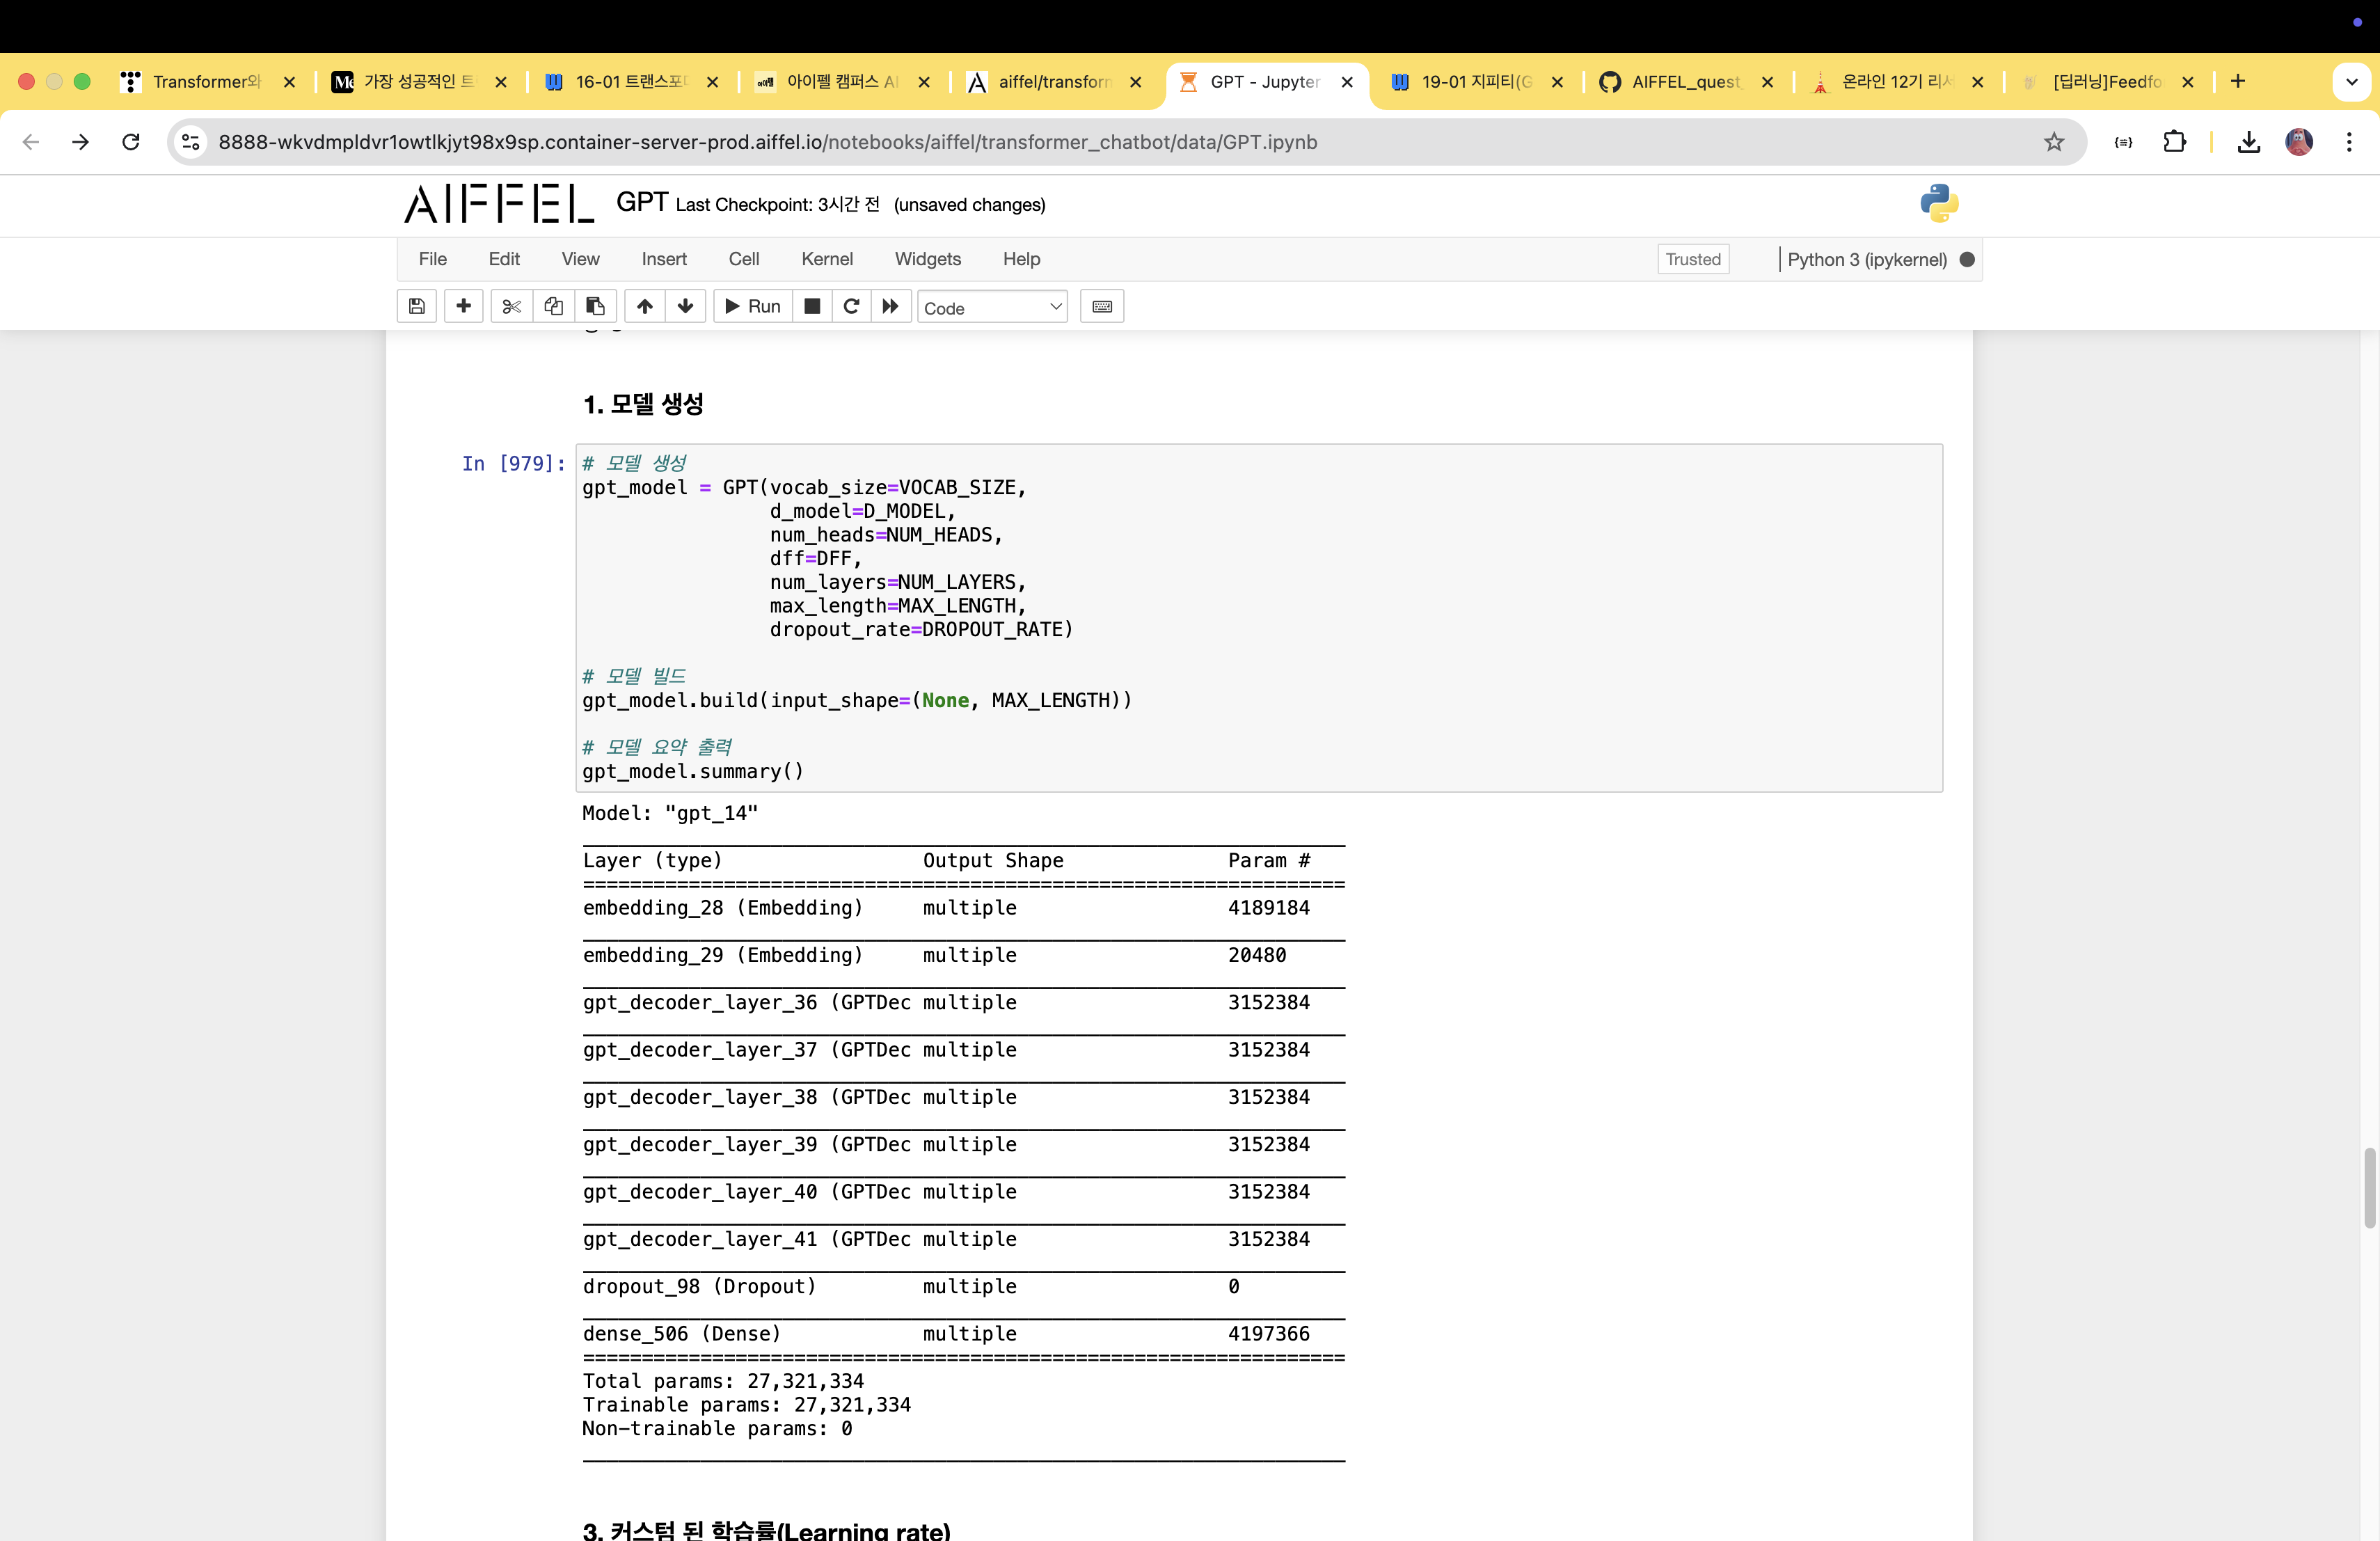

# model.fit

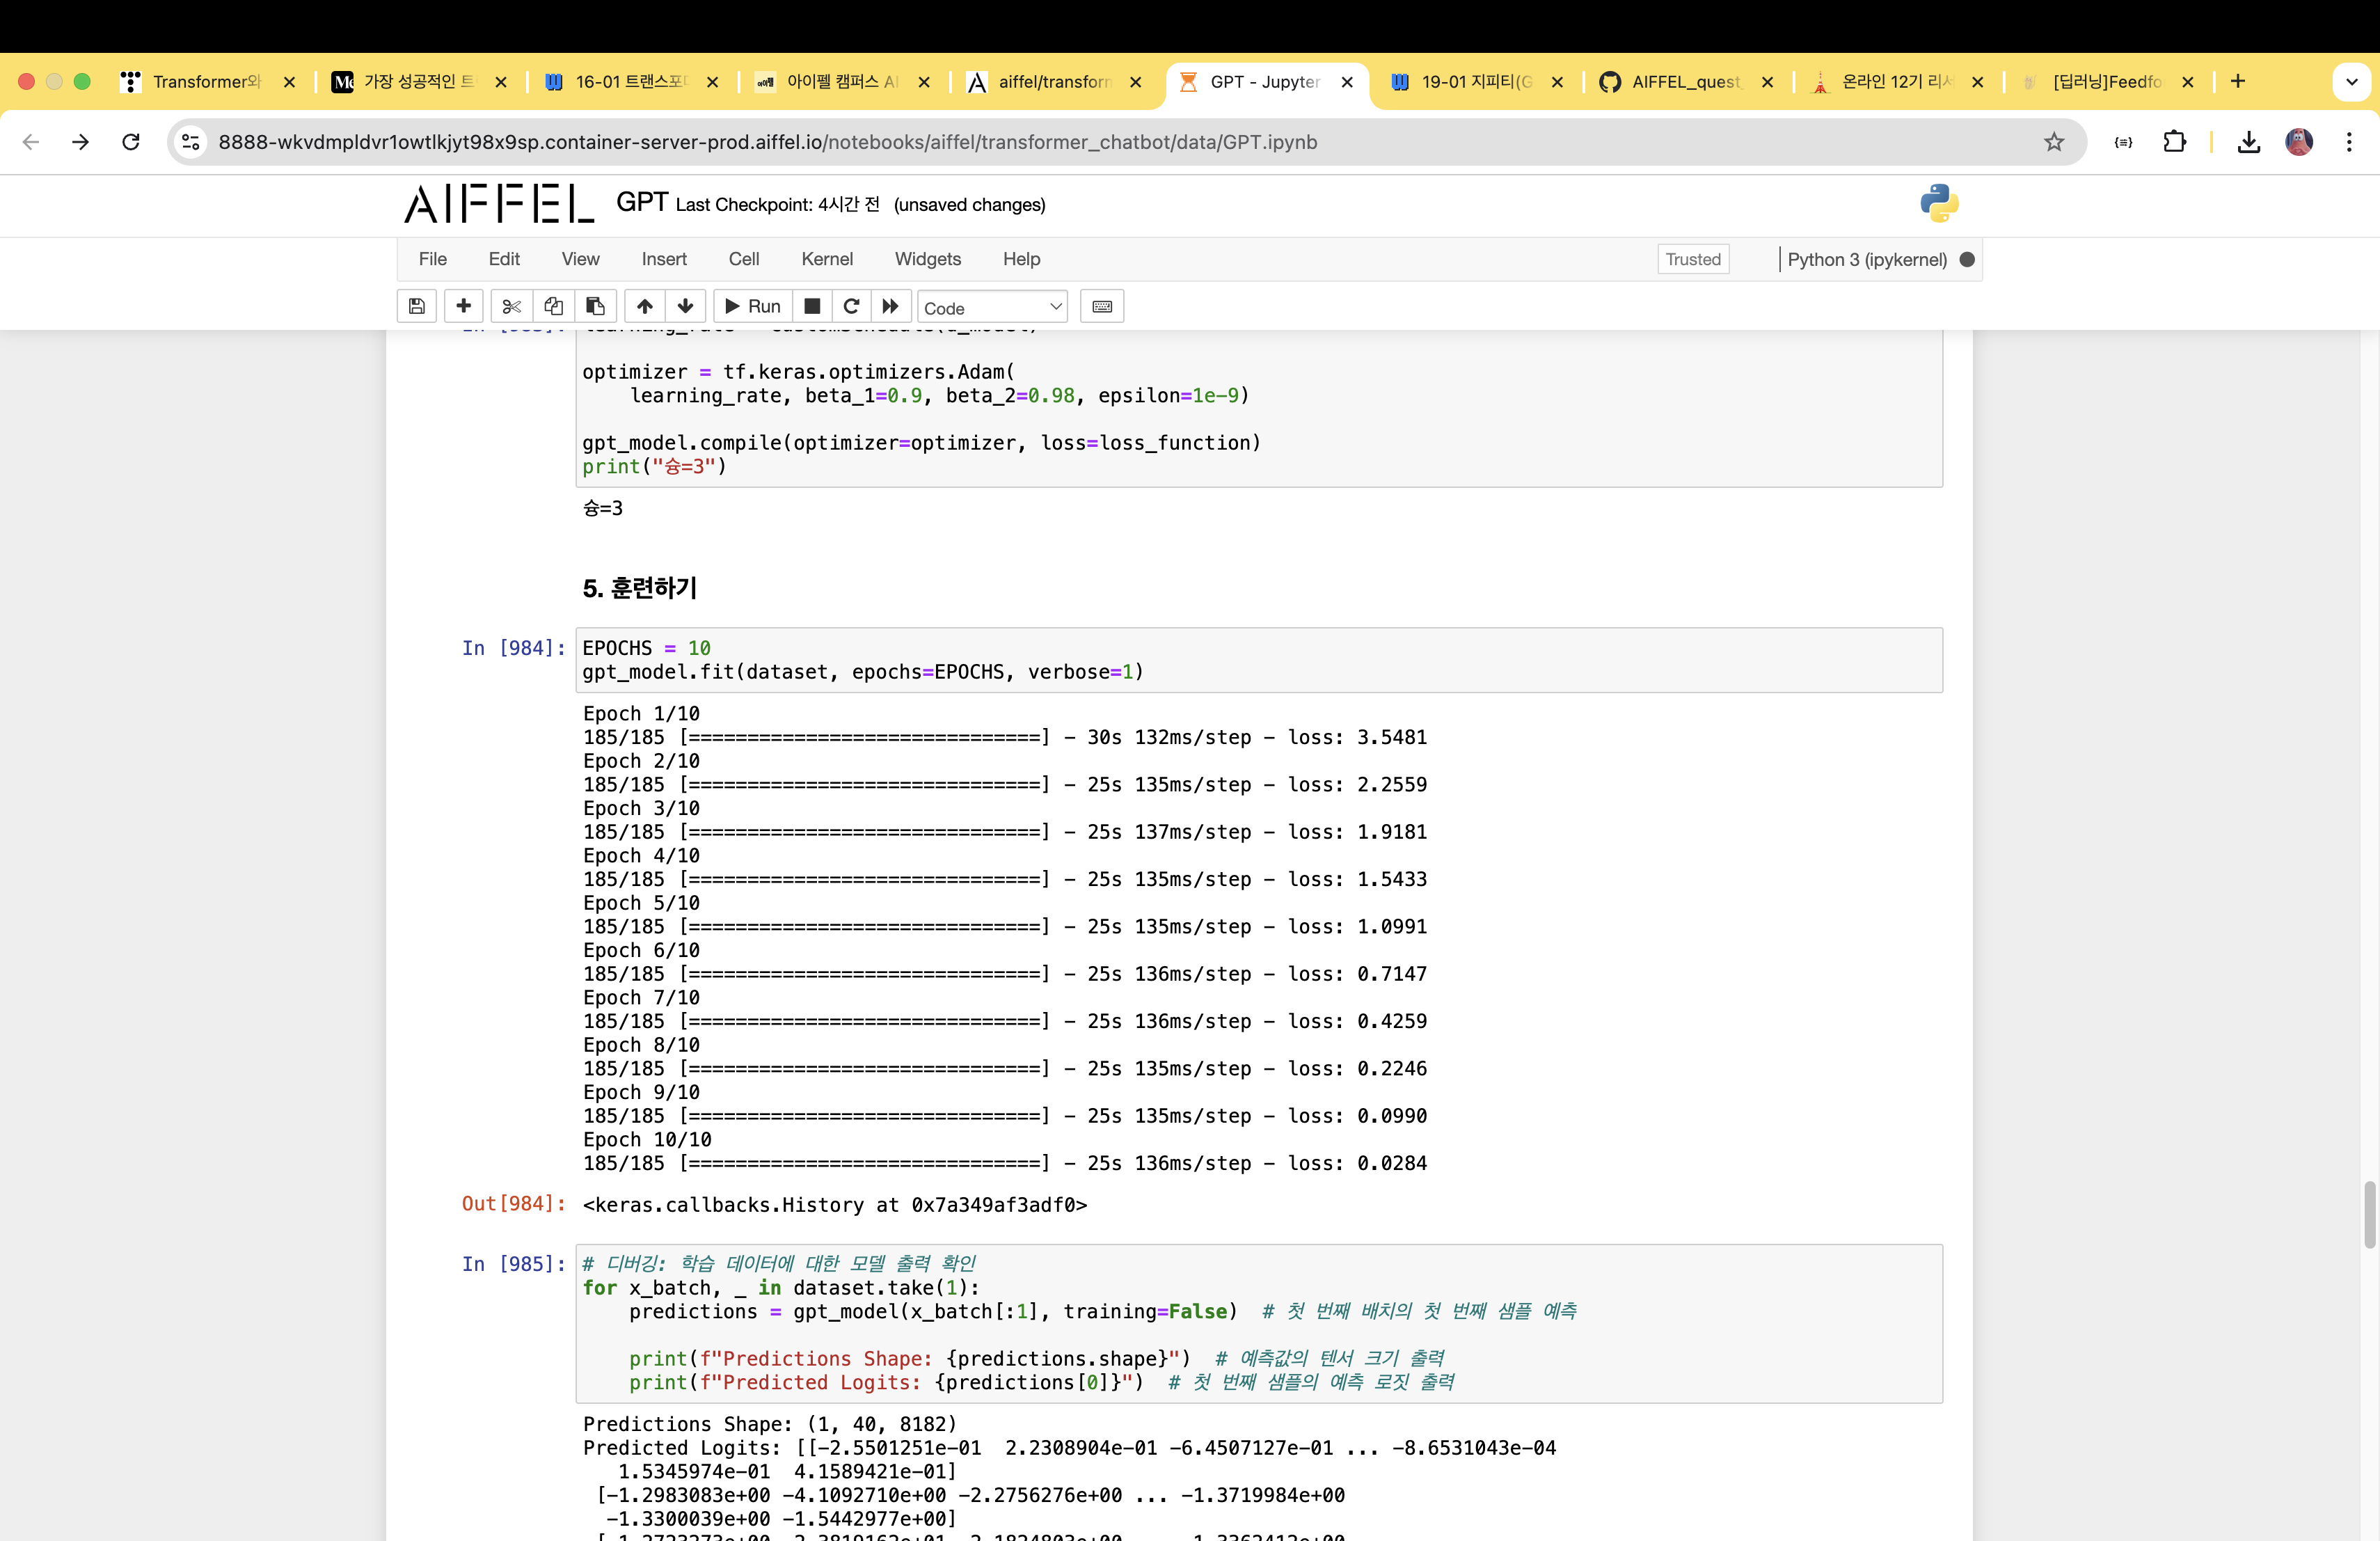